<h1>1. The Titanic Dataset : observations and first models<h1>

In [53]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder


train = pd.read_csv('data/train.csv')
X_truetest = pd.read_csv('data/test.csv')
index_id = X_truetest.PassengerId
print('Setup completed')

Setup completed


In [2]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


On observe que dans la but de prédire la survie des passagers, notre colonne des labels y va être 'Survived'. On est ici sur un problème de classification, nous devons prédire dans quelle classe se trouve nos passagers, c'est-à-dire si ils ont survécu ou non. L'idée ici va être de commencer par analyser nos colonnes afin de voir quels features nous allons garder, et ensuite de faire une classification dummy et comparer nos modèles entre eux.

**Important à noter :** le dataset fourni par Kaggle a déjà éliminé certaines colonnes: boat et body. Ces colonnes pouvaient avoir la tendance de spoiler le modèle, il est donc plus sage qu'elles soient absentes, si elles ne l'étaient pas nous aurions dû le faire nous même.

In [3]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [4]:
train.isnull().sum()  #On veut savoir le nombre de valeurs manquantes dans notre dataset

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Ce projet n'inclue pas de traitement du langage naturel, ainsi notre modèle ne pourra tirer profit d'une colonne dont les valeurs sont toutes différentes. On doit logiquement éliminer les colonnes 'Name', 'Ticket', 'Cabin' et 'PassengerId' (on aurait pu importer le df directement avec l'ID en index). On s'enlève par la même occasion le problème des données manquantes dans la colonne 'Cabin'.

In [5]:
train=train.drop(columns=['Cabin', 'Name', 'Ticket', 'PassengerId'])
train.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked'],
      dtype='object')

On va créer de nouvelles colonnes en encodant les lieux d'embarcations et le sexe des personnes à bord. On a deux options : le get_dummies de pandas ou le OneHotEncoder de sklearn. Comme on explore les données et qu'on ne veut pas faire une pipeline tout de suite, on va utiliser le get_dummies.

In [6]:
train=pd.get_dummies(train, drop_first=True)
train.columns

Index(['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_male',
       'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [7]:
X = train.drop(columns='Survived')
y=train.Survived

In [8]:
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X ,y, test_size=0.3, random_state=4)

On doit désormais imputer nos données car il nous en manque, notamment dans la colonne 'Age'. Pour cela on va utiliser les imputers de sklearn.

In [9]:
from sklearn.experimental import enable_iterative_imputer
from sklearn import impute
num_cols=['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
imputer=impute.IterativeImputer()
imputer.fit(X_train[num_cols])
imputed=imputer.transform(X_train[num_cols])
X_train.loc[:,num_cols]=imputed
imputed_t=imputer.transform(X_test[num_cols])
X_test.loc[:,num_cols]=imputed_t

On peut désormais standardiser nos données, toutefois on ne va pas standardiser nos colonnes factices.

In [10]:
from sklearn import preprocessing
scaler=preprocessing.StandardScaler()
cols= "Pclass,Age,SibSp,Parch,Fare".split(",")

scaler.fit(X_train[cols])
X_train.loc[:,cols] = scaler.transform(X_train[cols]).astype('int64')
X_test.loc[:,cols] = scaler.transform(X_test[cols]).astype('int64')

#We modified only the columns we were interested in, all of the columns except the created ones



<Axes: >

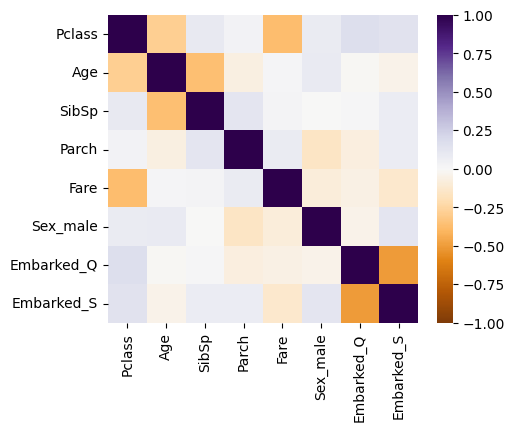

In [54]:
# Calcul de la matrice de corrélation deux à deux
corr_matrix = X_train.corr()

# Initialisation figure
plt.figure(figsize=(5, 4))

# Affichage heatmap
sns.heatmap(corr_matrix, 
            vmin=-1, # borne inf des valeurs à afficher
            vmax=1, # borne sup des valeurs à afficher
            center= 0, # valeur médiane des valeurs à afficher,
            cmap='PuOr', # colormap divergente de violet (PUrple) vers orange (ORange)
           )

On peut créer notre algorithme de référence avec le DummyClassifier dans le but de pouvoir comparer nos modèles par la suite.

In [11]:
from sklearn.dummy import DummyClassifier
bm=DummyClassifier()
bm.fit(X_train, y_train)
bm.score(X_test, y_test)

0.664179104477612

On va désormais tester différentes familles d'algorithmes, seulement nous allons faire des validations à k-plis donc on va redonner tout le dataset à étudier, on doit donc concaténer nos données à nouveau.

In [12]:
X_train=pd.DataFrame(X_train, columns=X_train.columns)
X_test=pd.DataFrame(X_test, columns=X_test.columns)
X=pd.concat([X_train, X_test]) 
y=pd.concat([y_train,y_test])

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [14]:
for model in [DummyClassifier, LogisticRegression, DecisionTreeClassifier, KNeighborsClassifier, GaussianNB, SVC, RandomForestClassifier, xgboost.XGBClassifier]:
    cls = model()
    kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=4)
    s=model_selection.cross_val_score(cls, X, y, scoring="roc_auc", cv=kfold)
    print(
        f"{model.__name__:22} AUC:"
        f"{s.mean():.3f}    STD:  {s.std():.2f}"
    )

DummyClassifier        AUC:0.500    STD:  0.00
LogisticRegression     AUC:0.851    STD:  0.04
DecisionTreeClassifier AUC:0.826    STD:  0.06
KNeighborsClassifier   AUC:0.817    STD:  0.05
GaussianNB             AUC:0.815    STD:  0.05
SVC                    AUC:0.814    STD:  0.06
RandomForestClassifier AUC:0.839    STD:  0.06
XGBClassifier          AUC:0.838    STD:  0.05


Looking at the results, we want to pursue the idea of a Random Forest Classifier. We are going now to create the model and try to optimize through the values of the hyperparameters, and to explore it we are going to use a Grid Search.

In [15]:
#We test again a model in order to have the value of accuracy or 'precision'
from sklearn import metrics
rf1=RandomForestClassifier(random_state=4)
rf1.fit(X_train,y_train)
print(rf1.score(X_test,y_test))
print(metrics.precision_score(y_test, rf1.predict(X_test)))

0.835820895522388
0.7395833333333334


Now we are optimizing with the hyperparameters !

In [16]:
rf=RandomForestClassifier(random_state=4)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [0.1, 1, 2],
    'max_features': ['sqrt', 'log2'],
    'random_state': [42]
}

grid = model_selection.GridSearchCV(rf, param_grid=param_grid, cv=kfold)

grid.fit(X_train,y_train)

,estimator,RandomForestC...andom_state=4)
,param_grid,"{'max_depth': [5, 10, ...], 'max_features': ['sqrt', 'log2'], 'min_samples_leaf': [0.1, 1, ...], 'min_samples_split': [2, 5], ...}"
,scoring,None
,n_jobs,None
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,100


In [17]:
print(grid.best_params_)

{'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100, 'random_state': 42}


In [18]:
rf_final = RandomForestClassifier ( max_depth=10, max_features='log2', min_samples_leaf=1, min_samples_split=5, n_estimators=100, random_state=42)
rf_final.fit(X_train, y_train)
rf_final.score(X_test, y_test)

0.8395522388059702

In [19]:
X.shape[0] == y.shape[0]

True

In [20]:
rf_final.fit(X,y)

,n_estimators,100
,criterion,'gini'
,max_depth,10
,min_samples_split,5
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'log2'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


On doit désormais refaire le même preprocessing pour notre dataset de test :

In [21]:
def process(df):
    df=df.drop(columns=['Cabin', 'Name', 'Ticket', 'PassengerId'])
    df=pd.get_dummies(df, drop_first=True)
    num_cols=['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
    df[num_cols] = df[num_cols].astype(float)
    imputed=imputer.transform(df[num_cols])
    df.loc[:,num_cols]=imputed

    cols= "Pclass,Age,SibSp,Parch,Fare".split(",")
    df.loc[:,cols] = scaler.transform(df[cols])

    return df

In [22]:
import pickle
pic=pickle.dumps(rf_final)
rf_final=pickle.loads(pic)
X_truetest=process(X_truetest)
y_pred=rf_final.predict(X_truetest)

pred=pd.DataFrame(y_pred, index=index_id, columns=["Survived"])
pred.to_csv('titanic_pred.csv')
pred.head()


,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,1


<h1>Feature Engineerings and Observation of the models' reactions<h1>

I submitted the 'rf_final' model to Kaggle and I received a 0,77 accuracy. It looks like it is a usual score for the dataset, although there is still some new things that I could add to continue to improve the model. One of the leads could be feature engeenering, in other words create new features like Title, or family size. I would also like to try to make a clean sklearn pipeline with the class Pipeline and ColumnTransformer.

In [23]:
train = pd.read_csv('data/train.csv')
X_truetest = pd.read_csv('data/test.csv')
index_id = X_truetest.PassengerId
print('Setup completed')

Setup completed


<h3>New columns : Title, Family, IsAlone<h3>

In [24]:
train['Title'] = train['Name'].apply(lambda name: name.split(',')[1].split('.')[0].strip())
train.Title.value_counts()


Title
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: count, dtype: int64

In [25]:
rare_titles = ['Don','Rev', 'Dr', 'Major', 'Jonkheer', 'Lady', 'Sir', 'the Countess', 'Ms', 'Capt', 'Col', ]
train.Title = train.Title.replace(rare_titles, 'Rare')
train.Title = train.Title.replace({'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs'})
train.Title.value_counts()


Title
Mr        517
Miss      184
Mrs       126
Master     40
Rare       24
Name: count, dtype: int64

In [26]:
train['Family']=train['Parch']+train['SibSp']+1
train=train.drop(columns=['Cabin', 'Name', 'Ticket', 'PassengerId'])

In [27]:
train=pd.get_dummies(train, drop_first=True)
train.columns

Index(['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Family',
       'Sex_male', 'Embarked_Q', 'Embarked_S', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_Rare'],
      dtype='object')

The goal here is to fill in the missing values with an imputer. It's an easy solution and it will be tackled again later beacause it is certain that we could do better with the title for exemple !

In [28]:
from sklearn.experimental import enable_iterative_imputer
from sklearn import impute
num_cols=['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
imputer=impute.IterativeImputer()
imputer.fit(train[num_cols])
imputed=imputer.transform(train[num_cols])
train.loc[:,num_cols]=imputed
imputed_t=imputer.transform(X_truetest[num_cols])
X_truetest.loc[:,num_cols]=imputed_t

We are here scaling our data, only the 'true' columns, true understood as not creted by get_dummies or the OneHotEncoder

In [29]:
from sklearn import preprocessing
scaler=preprocessing.StandardScaler()
cols= "Pclass,Age,SibSp,Parch,Fare".split(",")

scaler.fit(X_train[cols])
X_train.loc[:,cols] = scaler.transform(X_train[cols]).astype('int64')
X_truetest.loc[:,cols] = scaler.transform(X_truetest[cols]).astype('int64')

We are testing here the models without fine-tuning with the new columns to observe their comportements.

In [33]:
for model in [DummyClassifier, LogisticRegression, DecisionTreeClassifier, KNeighborsClassifier, GaussianNB, SVC, RandomForestClassifier, xgboost.XGBClassifier, GradientBoostingClassifier]:
    if model == LogisticRegression:
        cls = model(max_iter=10000)
    else:
        cls=model()
    kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=4)
    s=model_selection.cross_val_score(cls, train.drop(columns='Survived', axis = 1), train.Survived, scoring="accuracy", cv=kfold)
    print(
        f"{model.__name__:22} ACCURACY : "
        f"{s.mean():.3f}    STD:  {s.std():.2f}"
    )

DummyClassifier        ACCURACY : 0.616    STD:  0.05
LogisticRegression     ACCURACY : 0.821    STD:  0.03
DecisionTreeClassifier ACCURACY : 0.793    STD:  0.03
KNeighborsClassifier   ACCURACY : 0.726    STD:  0.02
GaussianNB             ACCURACY : 0.784    STD:  0.04
SVC                    ACCURACY : 0.688    STD:  0.05
RandomForestClassifier ACCURACY : 0.797    STD:  0.04
XGBClassifier          ACCURACY : 0.818    STD:  0.04
GradientBoostingClassifier ACCURACY : 0.837    STD:  0.05


On a vu comment on peut créer les nouvelles colonnes qui pourraient être intéressantes pour pouvoir faire de la prédiction. On va essayer de rendre tout ça propre désormais avec les class de sklearn pour tout automatiser.

<h1>Proper Pipeline Implementation<h1>

In [34]:
#On recharge nos données propres avant de faire la Pipeline
train = pd.read_csv('data/train.csv')
X = train.drop(columns=['Survived'])
y = train['Survived']
X_test = pd.read_csv('data/test.csv')

In [35]:
X_test.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip()).value_counts()

Name
Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Ms          1
Dr          1
Dona        1
Name: count, dtype: int64

In the FeatureEngineering class we create the new columns Title and Family, and we then immediatly mmodify the Title by giving a 'Rare' value to the values that we don't see often.

In [ ]:
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

class FeatureEngineering(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        X['Title'] = X['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
        X['Family'] = X['Parch'] + X['SibSp'] + 1
        rare_titles = ['Don','Rev', 'Dr', 'Major', 'Jonkheer', 'Lady', 'Sir', 'the Countess', 'Ms', 'Capt', 'Col', 'Dona']
        X.Title = X.Title.replace(rare_titles, 'Rare')
        X.Title = X.Title.replace({'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs'})
        X['cabin_adv']=X.Cabin.apply(lambda x : str(x)[0])
        X['cabin_multiple'] = X.Cabin.apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))

        X = X.drop(columns=['Cabin', 'Name', 'Ticket', 'PassengerId'])
        return X

In [40]:
numeric_features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Family']
categorical_features = ['Sex', 'Embarked', 'Title']

In [58]:
numeric_transformer = Pipeline([
    ('imputer', IterativeImputer(random_state=42)),
    ('scaler', preprocessing.PowerTransformer(method='yeo-johnson'))
])
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

pipeline = Pipeline([
    ('feat_eng', FeatureEngineering()),
    ('preproc', preprocessor),
    ('clf', XGBClassifier(random_state=42, eval_metric='logloss'))
])

pipeline2 = Pipeline([
    ('feat_eng', FeatureEngineering()),
    ('preproc', preprocessor),
    ('clf', GradientBoostingClassifier())
])
pipeline_log_reg = Pipeline([
    ('feat_eng', FeatureEngineering()),
    ('preproc', preprocessor),
    ('clf', LogisticRegression())
])
pipeline_rf = Pipeline([
    ('feat_eng', FeatureEngineering()),
    ('preproc', preprocessor),
    ('clf', RandomForestClassifier())
])


On va essayer un premier modèle avec XGBoost

In [59]:
param_grid = {
    'clf__n_estimators': [100, 200, 300],
    'clf__max_depth': [3, 4, 5],  # évite les très grands arbres
    'clf__learning_rate': [0.05, 0.1, 0.15],
    'clf__subsample': [0.8],  # évite de tester 1.0
    'clf__colsample_bytree': [0.8]
}

param_grid2 = {
    'clf__n_estimators': [200, 300],           # Nombre d’arbres
    'clf__learning_rate': [0.05, 0.1],        # Taux d’apprentissage
    'clf__max_depth': [4, 5],                    # Profondeur max des arbres
    'clf__min_samples_split': [5, 10],           # Min échantillons pour split
    'clf__min_samples_leaf': [3, 5],             # Min échantillons dans une feuille
    'clf__subsample': [0.8, 1.0],                   # Frac. d’échantillons pour chaque arbre (bagging)
    'clf__max_features': ['sqrt', 'log2']           # Nombre max de features utilisées pour split
}

param_grid_logreg = {
    'clf__penalty': ['l2', 'elasticnet', None],
    'clf__C': [0.01, 0.1, 1],  # Inverse de la régularisation
    'clf__solver': ['liblinear', 'saga'],  # Pour compatibilité avec l1 et elasticnet
    'clf__l1_ratio': [0, 0.5, 1]   # Seulement utilisé si penalty = 'elasticnet'
}

param_grid_rf = {
    'clf__max_depth': [3, 5, 10],
    'clf__min_samples_split': [2, 5],
    'clf__min_samples_leaf': [2, 4],
    'clf__max_features': ['sqrt', 'log2', None],
    'clf__criterion': ['gini', 'entropy']
}




kf = KFold(n_splits=10, shuffle=True, random_state=42)

# --- GridSearchCV avec KFold cross-validation ---
grid_search = GridSearchCV(pipeline, param_grid, cv=kf, scoring='accuracy', n_jobs=-1)
grid_search2 = GridSearchCV(pipeline2, param_grid2, cv=kf, scoring='accuracy', n_jobs=-1)
grid_search_log_reg = GridSearchCV(pipeline_log_reg, param_grid_logreg, cv=kf, scoring='accuracy', n_jobs=-1)
grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=kf, scoring='accuracy', n_jobs=-1)


In [60]:
grid_search.fit(X, y)
grid_search2.fit(X,y)
grid_search_log_reg.fit(X,y)
grid_search_rf.fit(X,y)

# --- Résultats ---
print("XGBoost")
print("Meilleurs paramètres :", grid_search.best_params_)
print("Meilleur score (accuracy):", grid_search.best_score_)

print("Gradient Boosting")
print("Meilleurs paramètres :", grid_search2.best_params_)
print("Meilleur score (accuracy):", grid_search2.best_score_)

print("Logistic Regression")
print("Meilleurs paramètres :", grid_search_log_reg.best_params_)
print("Meilleur score (accuracy):", grid_search_log_reg.best_score_)

print("Random Forest")
print("Meilleurs paramètres :", grid_search_rf.best_params_)
print("Meilleur score (accuracy):", grid_search_rf.best_score_)

/opt/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1213: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1213: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1213: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1213: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1213: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/miniconda3/lib/python3.13

XGBoost
Meilleurs paramètres : {'clf__colsample_bytree': 0.8, 'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__n_estimators': 200, 'clf__subsample': 0.8}
Meilleur score (accuracy): 0.8451061173533084
Gradient Boosting
Meilleurs paramètres : {'clf__learning_rate': 0.1, 'clf__max_depth': 4, 'clf__max_features': 'log2', 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 5, 'clf__n_estimators': 200, 'clf__subsample': 0.8}
Meilleur score (accuracy): 0.842896379525593
Logistic Regression
Meilleurs paramètres : {'clf__C': 1, 'clf__l1_ratio': 0, 'clf__penalty': 'l2', 'clf__solver': 'saga'}
Meilleur score (accuracy): 0.8159425717852684
Random Forest
Meilleurs paramètres : {'clf__criterion': 'gini', 'clf__max_depth': 10, 'clf__max_features': None, 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 5}
Meilleur score (accuracy): 0.8406367041198501


In [ ]:
y_pred = grid_search.best_estimator_.predict(X_test)
y_pred=pd.DataFrame(y_pred, index=index_id, columns=["Survived"])
#y_pred.to_csv('titanic_predGNB.csv')